In [1]:
from matplotlib import pyplot as plt
import matplotlib
% matplotlib inline

plt.style.use('seaborn')

import numpy as np
import json
import time
import os

experiment_dir = './experiments/1510174775-9449394'
figure_outdir = os.path.join(experiment_dir, 'figures')
if not os.path.isdir(figure_outdir):
    os.makedirs(figure_outdir)
    
plots_timestamp = experiment_timestamp = str(time.time()).replace('.', '-')

In [2]:
def load_json(filename):
    with open(filename) as fd:
        return dict(json.load(fd))

In [3]:
results_json_filenames = [
    os.path.join(experiment_dir, filename)
    for filename in os.listdir(experiment_dir)
    if filename.startswith('results_')
]

model_dirs = [
    os.path.join(experiment_dir, filename)
    for filename in os.listdir(experiment_dir)
    if filename.startswith('model_')
]
num_models = len(model_dirs)

In [4]:
trimmed_results_fns = sorted(results_json_filenames)

results_jsons = [
    load_json(filename)
    for filename in trimmed_results_fns
]

In [5]:
num_to_process = 64
measurements_dict = {}
for index in range(1, num_to_process + 1):
    index_str = str(index)
    for results_json in results_jsons:
        measurements = list(results_json[index_str]['raw'])
        if index_str in measurements_dict:
            measurements_dict[index_str]['raw'] += measurements
        else:
            measurements_dict[index_str] = {}
            measurements_dict[index_str]['raw'] = measurements

for index in range(1, num_to_process + 1):
    index_str = str(index)
    measurements_for_index = measurements_dict[index_str]['raw']
    num_measurements = len(measurements_for_index)
    measurements_dict[index_str]['mean'] = np.mean(measurements_for_index)
    measurements_dict[index_str]['std_err'] = np.std(measurements_for_index) / np.sqrt(num_measurements)
    if index == 1:
        print(len(measurements_for_index))

90


In [6]:
num_models = []
means = []
upper_bar = []
lower_bar = []
for index in range(1, num_to_process + 1):
    index_str = str(index)
    
    num_models.append(index)

    mean = measurements_dict[index_str]['mean']
    std_err = measurements_dict[index_str]['std_err']
    means.append(mean)
    upper_bar.append(mean + (1.96 * std_err))
    lower_bar.append(mean - (1.96 * std_err))
num_models = np.array(num_models)
means = np.array(means)
upper_bar = np.array(upper_bar)
lower_bar = np.array(lower_bar)

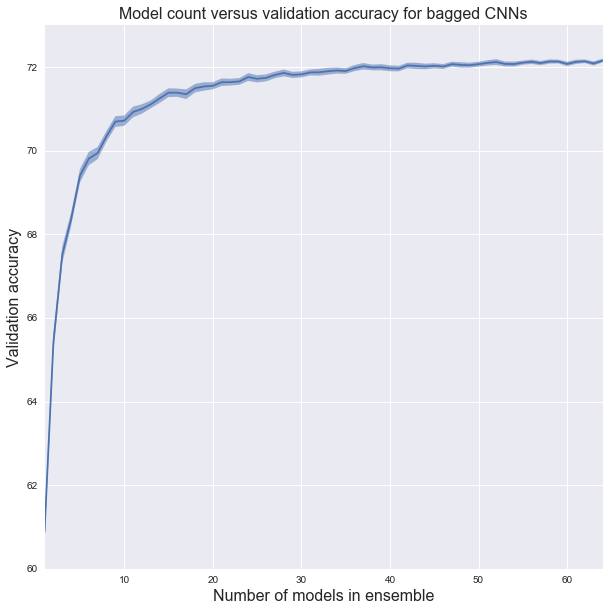

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(num_models, means)
plt.fill_between(num_models, lower_bar, upper_bar, alpha=0.5)
plt.xlim([1, num_to_process])
plt.ylim([np.floor(np.min(means)), np.ceil(np.max(means))])


#old_fontsize = matplotlib.rcParams['font.size']
#matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('Number of models in ensemble', fontsize=16)
plt.ylabel('Validation accuracy', fontsize=16)
plt.title('Model count versus validation accuracy for bagged CNNs', fontsize=16)
#matplotlib.rcParams.update({'font.size': old_fontsize})

plot_filename = os.path.join(figure_outdir, 'bagging_accuracy_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))

In [8]:
records = {
    'training_losses': {},
    'validation_losses': {},
    'validation_accuracies': {}
}

for model_dir in model_dirs:
    this_data = load_json(os.path.join(model_dir, 'train_stats.json'))
    this_training_loss = this_data['training_losses']
    this_validation_loss = this_data['validation_losses']
    this_validation_acc = this_data['validation_accuracies']

    enumerator = enumerate(zip(this_training_loss, this_validation_loss, this_validation_acc), 1)
    for epoch, (train_loss, val_loss, val_acc) in enumerator:
        if epoch in records['training_losses'].keys():
            records['training_losses'][epoch].append(train_loss)
            records['validation_losses'][epoch].append(val_loss)
            records['validation_accuracies'][epoch].append(val_acc)
        else:
            records['training_losses'][epoch] = [train_loss]
            records['validation_losses'][epoch] = [val_loss]
            records['validation_accuracies'][epoch] = [val_acc]

In [9]:
train_loss_vals = []
val_loss_vals = []
val_acc_vals = []
for key, val in records['training_losses'].items():
    train_loss_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
for key, val in records['validation_losses'].items():
    val_loss_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
for key, val in records['validation_accuracies'].items():
    val_acc_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
train_loss_vals = sorted(train_loss_vals)

In [10]:
epochs, train_loss_means, train_loss_standard_errors = map(np.array, zip(*train_loss_vals))
_, val_loss_means, val_loss_standard_errors = map(np.array, zip(*val_loss_vals))
_, val_acc_means, val_acc_standard_errors = map(np.array, zip(*val_acc_vals))

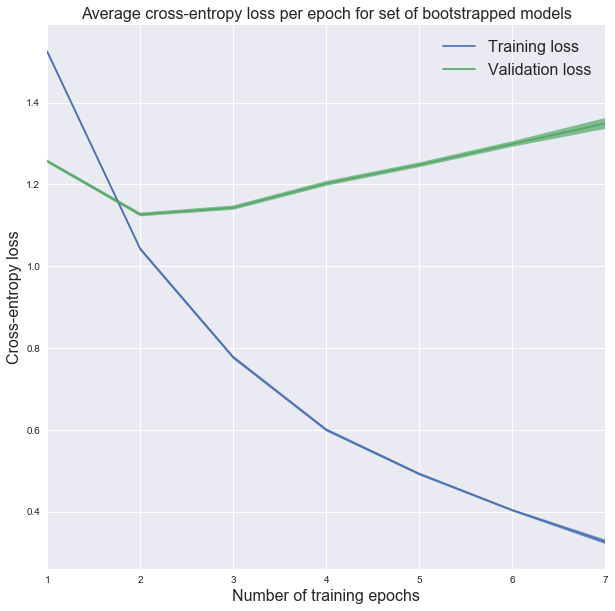

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(epochs[:-1], train_loss_means[:-1], label='Training loss')
plt.fill_between(
    epochs[:-1],
    train_loss_means[:-1] - 1.96 * train_loss_standard_errors[:-1],
    train_loss_means[:-1] + 1.96 * train_loss_standard_errors[:-1],
    alpha=0.7
)
plt.plot(epochs[:-1], val_loss_means[:-1], label='Validation loss')
plt.fill_between(
    epochs[:-1],
    val_loss_means[:-1] - 1.96 * val_loss_standard_errors[:-1],
    val_loss_means[:-1] + 1.96 * val_loss_standard_errors[:-1],
    alpha=0.7
)
plt.xlim([1, 7])

plt.legend(loc='upper right', fontsize=16)

plt.xlabel('Number of training epochs', fontsize=16)
plt.ylabel('Cross-entropy loss', fontsize=16)
plt.title('Average cross-entropy loss per epoch for set of bootstrapped models', fontsize=16)

plot_filename = os.path.join(figure_outdir, 'bagging_train_val_losses_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))

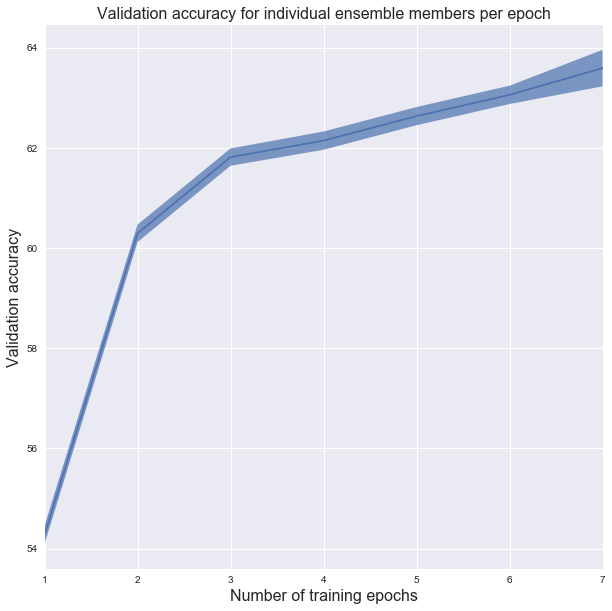

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(epochs[:-1], val_acc_means[:-1])
plt.fill_between(
    epochs[:-1],
    val_acc_means[:-1] - 1.96 * val_acc_standard_errors[:-1],
    val_acc_means[:-1] + 1.96 * val_acc_standard_errors[:-1],
    alpha=0.7
)
plt.xlim([1, 7])

plt.xlabel('Number of training epochs', fontsize=16)
plt.ylabel('Validation accuracy', fontsize=16)
plt.title('Validation accuracy for individual ensemble members per epoch', fontsize=16)

plot_filename = os.path.join(figure_outdir, 'bagging_val_acc_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))

In [97]:
import re
experiment_dir = './experiments/1510590320-4256678'
figure_outdir = os.path.join(experiment_dir, 'figures')
if not os.path.isdir(figure_outdir):
    os.makedirs(figure_outdir)

lambda_dirnames, lambda_qualified_dirnames = zip(*[
    (filename, os.path.join(ensemble_exp_path_name, filename))
    for filename in os.listdir(ensemble_exp_path_name)
    if re.match('^\d.\d\d$', filename)
])

In [115]:
def get_sorted_subfolder_names(lbd_dirname):
    print(lbd_dirname)
    def int_slug_comparator(dirname):
        return int(dirname.split('_')[-1])
    
    dir_listing = [
        entry 
        for entry in os.listdir(lbd_dirname)
        if entry.startswith('ensemble_')
    ]
    ensembles_for_lambda = [
        os.path.join(lbd_dirname, model_path)
        for model_path in sorted(dir_listing, key=int_slug_comparator)
    ]
    return ensembles_for_lambda

In [99]:
results_dict = {}
lambda_vals = map(float, lbd_dirnames)
for lambda_val, lambda_dirname in zip(lambda_vals, lambda_qualified_dirnames):    
    subfolder_names = get_sorted_subfolder_names(lambda_dirname)
    print(lambda_val)
    stats_files = [
        os.path.join(subfolder_name, 'train_stats.json')
        for subfolder_name in subfolder_names
    ]
    for num_models, stats_file in enumerate(stats_files, 1):
        json_data = load_json(stats_file)
        val_acc_at_min_loss = json_data['validation_accuracies'][
            np.argmin(json_data['validation_losses'])]
        print(num_models, val_acc_at_min_loss)
        
        if num_models in results_dict:
            results_dict[num_models]['lambdas'].append(lambda_val)
            results_dict[num_models]['val_accs'].append(val_acc_at_min_loss)
        else:
            results_dict[num_models] = {
                'lambdas': [lambda_val],
                'val_accs': [val_acc_at_min_loss]
            }

./experiments/1510590320-4256678/0.00
0.0
1 74.46000000000001
2 78.75999999999999
3 79.7
4 80.14
./experiments/1510590320-4256678/1.00
1.0
1 74.82
2 75.78
3 75.33999999999999
4 76.03999999999999
./experiments/1510590320-4256678/0.40
0.4
1 74.4
2 78.5
3 80.24
4 80.25999999999999
./experiments/1510590320-4256678/0.60
0.6
1 74.06
2 78.62
3 79.97999999999999
4 78.78
./experiments/1510590320-4256678/0.80
0.8
1 75.12
2 75.86
3 79.28
4 78.62
./experiments/1510590320-4256678/0.20
0.2
1 75.72
2 78.52
3 79.22
4 79.60000000000001


In [100]:
plot_dict = {}
for key, val in results_dict.items():
    lambda_and_acc = sorted(zip(val['lambdas'], val['val_accs']))
    lambdas, acc = zip(*lambda_and_acc)
    plot_dict[key] = np.array(acc)
lambdas = np.array(lambdas)

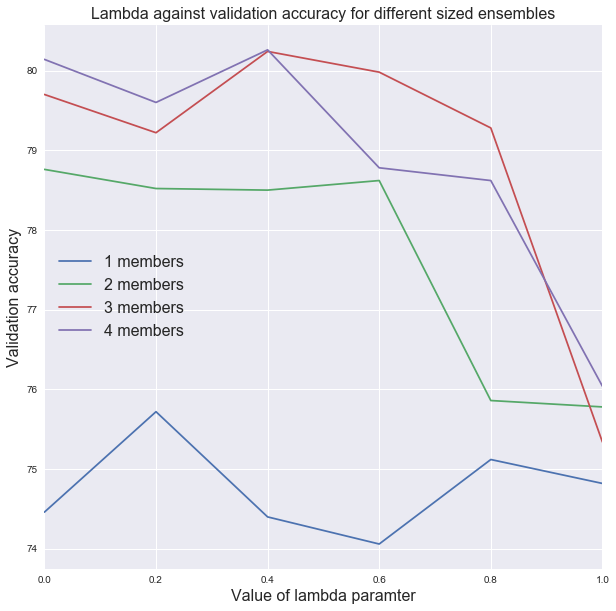

In [107]:
plt.figure(figsize=(10, 10))
for num_models, accs in plot_dict.items():
    plt.plot(lambdas, accs, label='{} members'.format(num_models))
plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.xlabel('Value of lambda paramter', fontsize=16)
plt.ylabel('Validation accuracy', fontsize=16)
plt.title('Lambda against validation accuracy for different sized ensembles', fontsize=16)

plot_filename = os.path.join(figure_outdir, 'nc_val_acc_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))

In [124]:
results_loss_dict = {}
lambda_vals = map(float, lbd_dirnames)
for lambda_val, lambda_dirname in zip(lambda_vals, lambda_qualified_dirnames):    
    subfolder_names = get_sorted_subfolder_names(lambda_dirname)
    print(lambda_val)
    stats_files = [
        os.path.join(subfolder_name, 'train_stats.json')
        for subfolder_name in subfolder_names
    ]
    for model_count, stats_file in enumerate(stats_files, 1):
        data = load_json(stats_file)
        
        if model_count in results_loss_dict:
            results_loss_dict[model_count][lambda_val] = {
                'validation_losses': data['validation_losses'],
                'training_losses': data['training_losses']
            }
        else:
            results_loss_dict[model_count] = {
                lambda_val: {
                    'validation_losses': data['validation_losses'],
                    'training_losses': data['training_losses']
                }
            }

./experiments/1510590320-4256678/0.00
0.0
1
{'training_losses': [1.3800571833716497, 0.9529396670394473, 0.7679097461038162, 0.6432346342669593, 0.5438747030496597, 0.47263308631049256, 0.40260295569896704, 0.343709524836805], 'validation_losses': [1.0382777452468872, 0.8375539183616638, 0.7720967531204224, 0.7666680812835693, 0.7715802788734436, 0.8371577858924866, 0.8297603726387024, 0.8790215849876404], 'validation_accuracies': [63.42, 70.98, 73.92, 74.46000000000001, 75.52, 74.46000000000001, 75.58, 76.3]}

2
{'training_losses': [1.376423040628434, 0.95117112716039, 0.7655108926031322, 0.6376798072126174, 0.5398449571265118, 0.46881354120042595, 0.39926702294084754, 0.3419951186908618], 'validation_losses': [1.0296108722686768, 0.847000002861023, 0.7595023512840271, 0.7235534191131592, 0.7338855266571045, 0.7586655020713806, 0.7919366359710693, 0.7917838096618652], 'validation_accuracies': [66.9, 74.02, 77.3, 78.75999999999999, 79.5, 79.92, 80.44, 80.25999999999999]}

3
{'training_

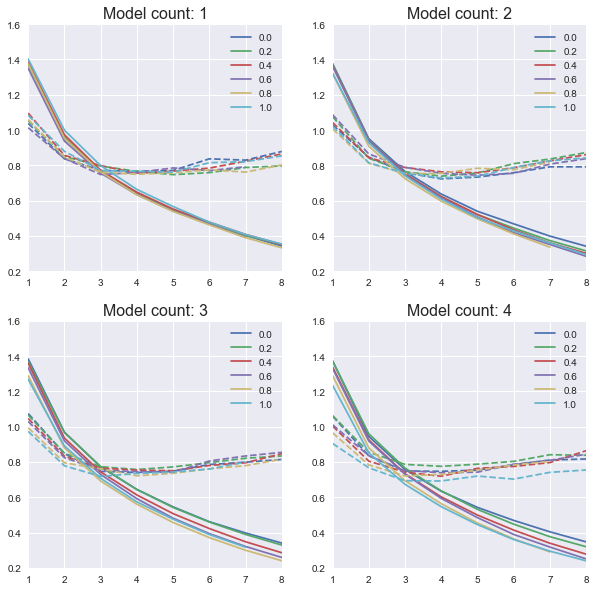

In [168]:
plt.figure(figsize=(10, 10))
subplot_num = {1: 221, 2: 222, 3: 223, 4: 224}
for model_count, this_loss_dict in results_loss_dict.items():
    plt.subplot(subplot_num[model_count])
    colours = (c  for c in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for lambda_val, losses_dict in sorted(this_loss_dict.items()):
        c = next(colours)
        plt.plot(*zip(*enumerate(losses_dict['training_losses'], 1)), c=c, label=lambda_val)
        plt.plot(*zip(*enumerate(losses_dict['validation_losses'], 1)), '--', c=c)
    plt.xlim([1, 8])
    plt.ylim([0.2, 1.6])
    plt.title('Model count: {}'.format(model_count), fontsize=16)
    plt.legend()

plot_filename = os.path.join(figure_outdir, 'nc_losses_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))